dataset = https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [1]:
import tensorflow as tf 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load data using a Keras utility image_dataset_from_directory

In [3]:
train_data_dir = os.path.join(os.curdir, 'Training')
train_data_dir

'.\\Training'

In [4]:
test_data_dir = os.path.join(os.curdir, 'Testing')
test_data_dir

'.\\Testing'

In [5]:
batch_size = 10
img_height = 256
img_width = 256

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    image_size=(256, 256),
    validation_split=0.2,
    subset='training',
    seed=123
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [7]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=batch_size,
    image_size=(256, 256),
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [8]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=batch_size,
    image_size=(256, 256),
    seed=123
)

Found 394 files belonging to 4 classes.


In [9]:
class_names = train_ds.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

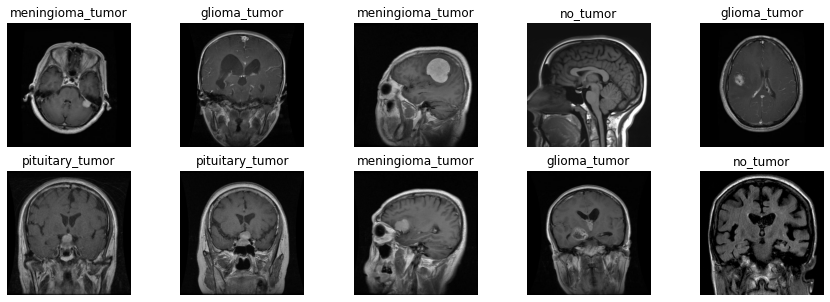

In [10]:
plt.figure(figsize=(15,5))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8")) # bcz image was in tensor float32 ,turn into numpy array int8
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 256, 256, 3)
(10,)


The image_batch is a tensor of the shape (32, 256, 256, 3). This is a batch of 32 images of shape 256x256x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
# Notice the pixel values are not scaled
print(np.min(first_image), np.max(first_image))

0.0 239.0


Data Augmentation

In [14]:
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
#     keras.layers.RandomTranslation(height_factor=0.2,
#                                    width_factor=(-0.2, 0.3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
#     keras.layers.RandomContrast(0.1),
#     keras.layers.RandomCrop(height=img_height, 
#                             width=img_width),
      
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

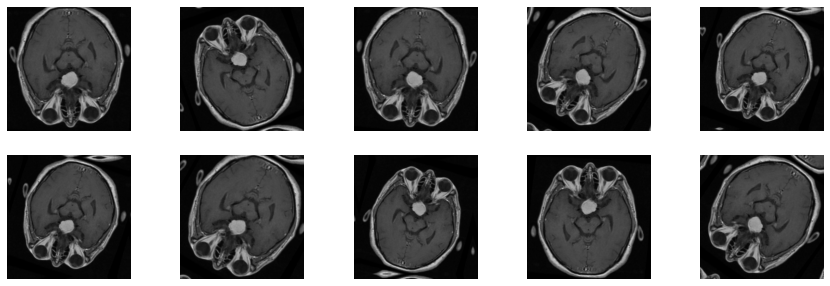

In [15]:
plt.figure(figsize=(15,5))
for images, _ in train_ds.take(1):
  for i in range(10):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Import pretrained model :EfficientNetB7 , Xception

In [16]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, 
                                          input_shape=(256,256,3),
                                          weights='imagenet')

In [17]:
xception_base_model = keras.applications.xception.Xception(include_top=False,
                                                          input_shape=(256,256,3),
                                                          weights='imagenet')

Build Model

In [18]:
num_classes = len(class_names)

xception_base_model.trainable = False

base_model.trainable = False

In [19]:
model = keras.models.Sequential([
    data_augmentation,
    keras.layers.Rescaling(1./255),
    xception_base_model,
    
    keras.layers.Flatten(),  # Flatten the output to feed to Dense layer
    
    keras.layers.Dense(50, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 50)                6553650   
                                                                 
 batch_normalization_4 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                      

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('Brain_tumor_model.h5',
                                                save_best_only=True )

In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                 restore_best_weights=True)

In [24]:
keras.backend.clear_session() 

Fine tune (train) top layers 

In [25]:
epochs = 7
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
    callbacks=[checkpoint_cb],
)

Epoch 1/7
230/230 [==============================] - 114s 463ms/step - loss: 1.0398 - accuracy: 0.5732 - val_loss: 0.6273 - val_accuracy: 0.7787
Epoch 2/7
230/230 [==============================] - 127s 541ms/step - loss: 0.7124 - accuracy: 0.7282 - val_loss: 0.5022 - val_accuracy: 0.8136
Epoch 3/7
230/230 [==============================] - 144s 614ms/step - loss: 0.6917 - accuracy: 0.7356 - val_loss: 0.4367 - val_accuracy: 0.8380
Epoch 4/7
230/230 [==============================] - 143s 611ms/step - loss: 0.6069 - accuracy: 0.7652 - val_loss: 0.4133 - val_accuracy: 0.8502
Epoch 5/7
230/230 [==============================] - 140s 599ms/step - loss: 0.5940 - accuracy: 0.7679 - val_loss: 0.4801 - val_accuracy: 0.8153
Epoch 6/7
230/230 [==============================] - 142s 609ms/step - loss: 0.5599 - accuracy: 0.7888 - val_loss: 0.3687 - val_accuracy: 0.8693
Epoch 7/7
230/230 [==============================] - 146s 623ms/step - loss: 0.5397 - accuracy: 0.7953 - val_loss: 0.3700 - val_ac

unfreeze base_model and train entire model with much lower lr to avoid damaging pretrained weights

In [26]:
xception_base_model.trainable = True

In [27]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [28]:
with tf.device('/CPU:0'):
    history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=20,  
  callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/20
230/230 [==============================] - 1462s 6s/step - loss: 0.9995 - accuracy: 0.5858 - val_loss: 5.1788 - val_accuracy: 0.3223
Epoch 2/20
230/230 [==============================] - 1455s 6s/step - loss: 0.8374 - accuracy: 0.6677 - val_loss: 0.5510 - val_accuracy: 0.8118
Epoch 3/20
230/230 [==============================] - 1454s 6s/step - loss: 0.6868 - accuracy: 0.7452 - val_loss: 0.6295 - val_accuracy: 0.7578
Epoch 4/20
230/230 [==============================] - 1454s 6s/step - loss: 0.5310 - accuracy: 0.8149 - val_loss: 0.3571 - val_accuracy: 0.8589
Epoch 5/20
230/230 [==============================] - 1457s 6s/step - loss: 0.5054 - accuracy: 0.8280 - val_loss: 0.3234 - val_accuracy: 0.8833
Epoch 6/20
230/230 [==============================] - 1458s 6s/step - loss: 0.4641 - accuracy: 0.8402 - val_loss: 0.2564 - val_accuracy: 0.9077
Epoch 7/20
230/230 [==============================] - 1451s 6s/step - loss: 0.3588 - accuracy: 0.8837 - val_loss: 0.2667 - val_accuracy:

In [29]:
model.evaluate(test_ds)

40/40 [==============================] - 12s 269ms/step - loss: 1.4754 - accuracy: 0.7462


[1.4754303693771362, 0.7461928725242615]